# Collecting and using GBIF data

The purpose of this case study is to demonstrate how to retrieve data from GBIF, and use them to extract environmental conditions from a series of layers.

In [1]:
using SpeciesDistributionToolkit
using CairoMakie
using Statistics
import Downloads
import Images
CairoMakie.activate!(px_per_unit = 6.0)

We start by defining which species we want to work on:

In [2]:
tx = taxon("Akodon montensis")

GBIF taxon -- Akodon montensis

When this is done, we can query the initial set of occurrences. The query arguments are the same as the arguments to the GBIF occurrence API, [the documentation of which is available online](https://techdocs.gbif.org/en/openapi/).

In [ ]:
occ = occurrences(tx, "occurrenceStatus" => "PRESENT", "country" => "PY", "limit" => 100, "hasCoordinate" => true)

GBIF records: downloaded 300 out of 562

This object is only the first page of the records, so we can start a loop to query more of them. Note that for very large number of occurrences, this can be prohibitively slow. For this reason, we are currently adding support to the download API to the **GBIF** package.

In [4]:
while length(occ) < count(occ)
    occurrences!(occ)
end
println("Retrieved $(length(occ)) occurrences")

Retrieved 562 occurrences

Before moving on, we will use **Phylopic** to download a silhouette for the species we work on:


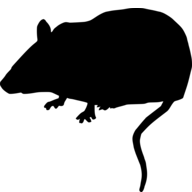

In [5]:
sp_uuid = Phylopic.imagesof(tx; items = 1)
sp_thumbnail_url = Phylopic.thumbnail(sp_uuid)
sp_thumbnail_tmp = Downloads.download(sp_thumbnail_url)
sp_image = Images.load(sp_thumbnail_tmp)

The attribution of the image can be collected as well (and should be included whenever it is not a public domain dedication):

In [6]:
Phylopic.attribution(sp_uuid)

We will re-use the same approach to the layer download as in the previous case study, and therefore will not go quite in depth in the code.

In [7]:
provider = RasterData(CHELSA2, BioClim)

RasterData{CHELSA2, BioClim}(CHELSA2, BioClim)

Note, here, that we will get the bounding box for the occurrences, and only read the relevant part of the layers. We used the same approach with the bounding box for the polygon in the previous case study:

In [8]:
spatial_extent = SpeciesDistributionToolkit.boundingbox(occ)

(left = -58.0815, right = -54.388722, bottom = -26.755333, top = -23.813)

In the next code cell, we will load the raster data, and immediately convert them in the right scale (different databases store the information with different scales and offsets). Layers, here, behave as numbers for the purpose of adding and mutliplying, which leads to shorter code:

In [9]:
temperature = 0.1SDMLayer(provider; layer = "BIO1", spatial_extent...)-271
precipitation = 0.1SDMLayer(provider; layer = "BIO12", spatial_extent...)

🗺️  A 354 × 444 layer with 157176 Float64 cells
   Projection: +proj=longlat +datum=WGS84 +no_defs

Before we move on with the figure, we can use the `layer[occurrences]` syntax to extract some of the values (and get the median). This syntax illustrates one of the ways in which **SDT** overloads the usual array indexing syntax, to rapidly extract the data stored in a layer at positions specified by occurrences.

In [10]:
temperature[occ] |> median

23.600000000000023

The rest of the vignette is simply data visualisation:

In [11]:
figure = Figure(; size = (600, 400))
ax =
    Axis(figure[1, 1]; xlabel = "Annual mean temperature (°C)", ylabel = "Annual precipitation (kg×m⁻²)")
scatter!(ax, temperature[occ], precipitation[occ], markersize=12, color=:white, strokecolor=:black, strokewidth=2)

Scatter{Tuple{Vector{Point{2, Float64}}}}

This little incantation is just to make sure that the silhouette is scaled properly, as SVG support for **Makie** is not quite as developped as we would like.

In [12]:
sp_size = Vec2f(reverse(size(sp_image) ./ 2.5))

2-element Vec{2, Float32} with indices SOneTo(2):
 76.8
 76.8

We finally add the silhouette:

In [13]:
scatter!(ax, [22.7], [1700.0]; marker = sp_image, markersize = sp_size)

Scatter{Tuple{Vector{Point{2, Float64}}}}

This is the final figure that will be shown in the manuscript:

In [14]:
figure